In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

np.random.seed(42)
from sklearn.metrics import confusion_matrix

import keras
from keras.utils import to_categorical
 # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder

In [23]:
data= pd.read_csv('dataset/HAM10000/HAM10000_metadata.csv')
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [24]:
#Now time to read images based on image ID from the CSV file
#This is the safest way to read images as it ensures the right image is read for the right ID
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('dataset/HAM10000/', '*', '*.jpg'))}
data['path']=data['image_id'].map(image_path.get)
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,dataset/HAM10000\HAM10000_images_part_1\ISIC_0...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,dataset/HAM10000\HAM10000_images_part_1\ISIC_0...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,dataset/HAM10000\HAM10000_images_part_1\ISIC_0...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,dataset/HAM10000\HAM10000_images_part_1\ISIC_0...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,dataset/HAM10000\HAM10000_images_part_2\ISIC_0...


In [25]:
# applied only on the training set
df = data.groupby('dx').apply(lambda x: x.sample(500, replace=True))
df = df.reset_index(drop=True)
df.head()

C:\Users\USER\AppData\Local\Temp\ipykernel_23840\2361703835.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = data.groupby('dx').apply(lambda x: x.sample(500, replace=True))


,lesion_id,image_id,dx,dx_type,age,sex,localization,path
0,HAM_0003136,ISIC_0026645,akiec,histo,65.0,male,back,dataset/HAM10000\HAM10000_images_part_1\ISIC_0...
1,HAM_0006587,ISIC_0025780,akiec,histo,70.0,male,face,dataset/HAM10000\HAM10000_images_part_1\ISIC_0...
2,HAM_0005505,ISIC_0024450,akiec,histo,50.0,male,upper extremity,dataset/HAM10000\HAM10000_images_part_1\ISIC_0...
3,HAM_0003455,ISIC_0027896,akiec,histo,75.0,male,hand,dataset/HAM10000\HAM10000_images_part_1\ISIC_0...
4,HAM_0005459,ISIC_0029268,akiec,histo,85.0,male,upper extremity,dataset/HAM10000\HAM10000_images_part_1\ISIC_0...


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     3500 non-null   object 
 1   image_id      3500 non-null   object 
 2   dx            3500 non-null   object 
 3   dx_type       3500 non-null   object 
 4   age           3491 non-null   float64
 5   sex           3500 non-null   object 
 6   localization  3500 non-null   object 
 7   path          3500 non-null   object 
dtypes: float64(1), object(7)
memory usage: 218.9+ KB


In [27]:
df['image_id'].duplicated().sum()

1387

In [28]:
# label encoding to numeric values from text
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df['dx'])
LabelEncoder()
print(list(le.classes_))
df['label'] = le.transform(df["dx"])
df.head()

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


,lesion_id,image_id,dx,dx_type,age,sex,localization,path,label
0,HAM_0003136,ISIC_0026645,akiec,histo,65.0,male,back,dataset/HAM10000\HAM10000_images_part_1\ISIC_0...,0
1,HAM_0006587,ISIC_0025780,akiec,histo,70.0,male,face,dataset/HAM10000\HAM10000_images_part_1\ISIC_0...,0
2,HAM_0005505,ISIC_0024450,akiec,histo,50.0,male,upper extremity,dataset/HAM10000\HAM10000_images_part_1\ISIC_0...,0
3,HAM_0003455,ISIC_0027896,akiec,histo,75.0,male,hand,dataset/HAM10000\HAM10000_images_part_1\ISIC_0...,0
4,HAM_0005459,ISIC_0029268,akiec,histo,85.0,male,upper extremity,dataset/HAM10000\HAM10000_images_part_1\ISIC_0...,0


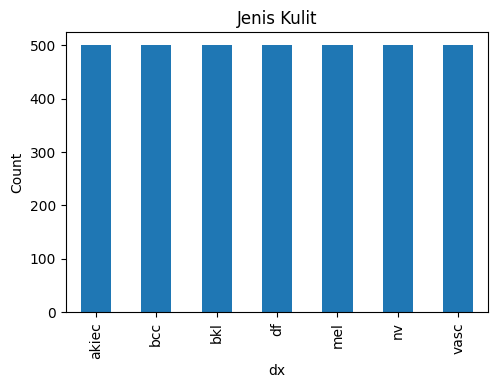

In [29]:
# df distribution visualization
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Jenis Kulit');

plt.show()

In [30]:
import numpy as np
from PIL import Image
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((64,64))))

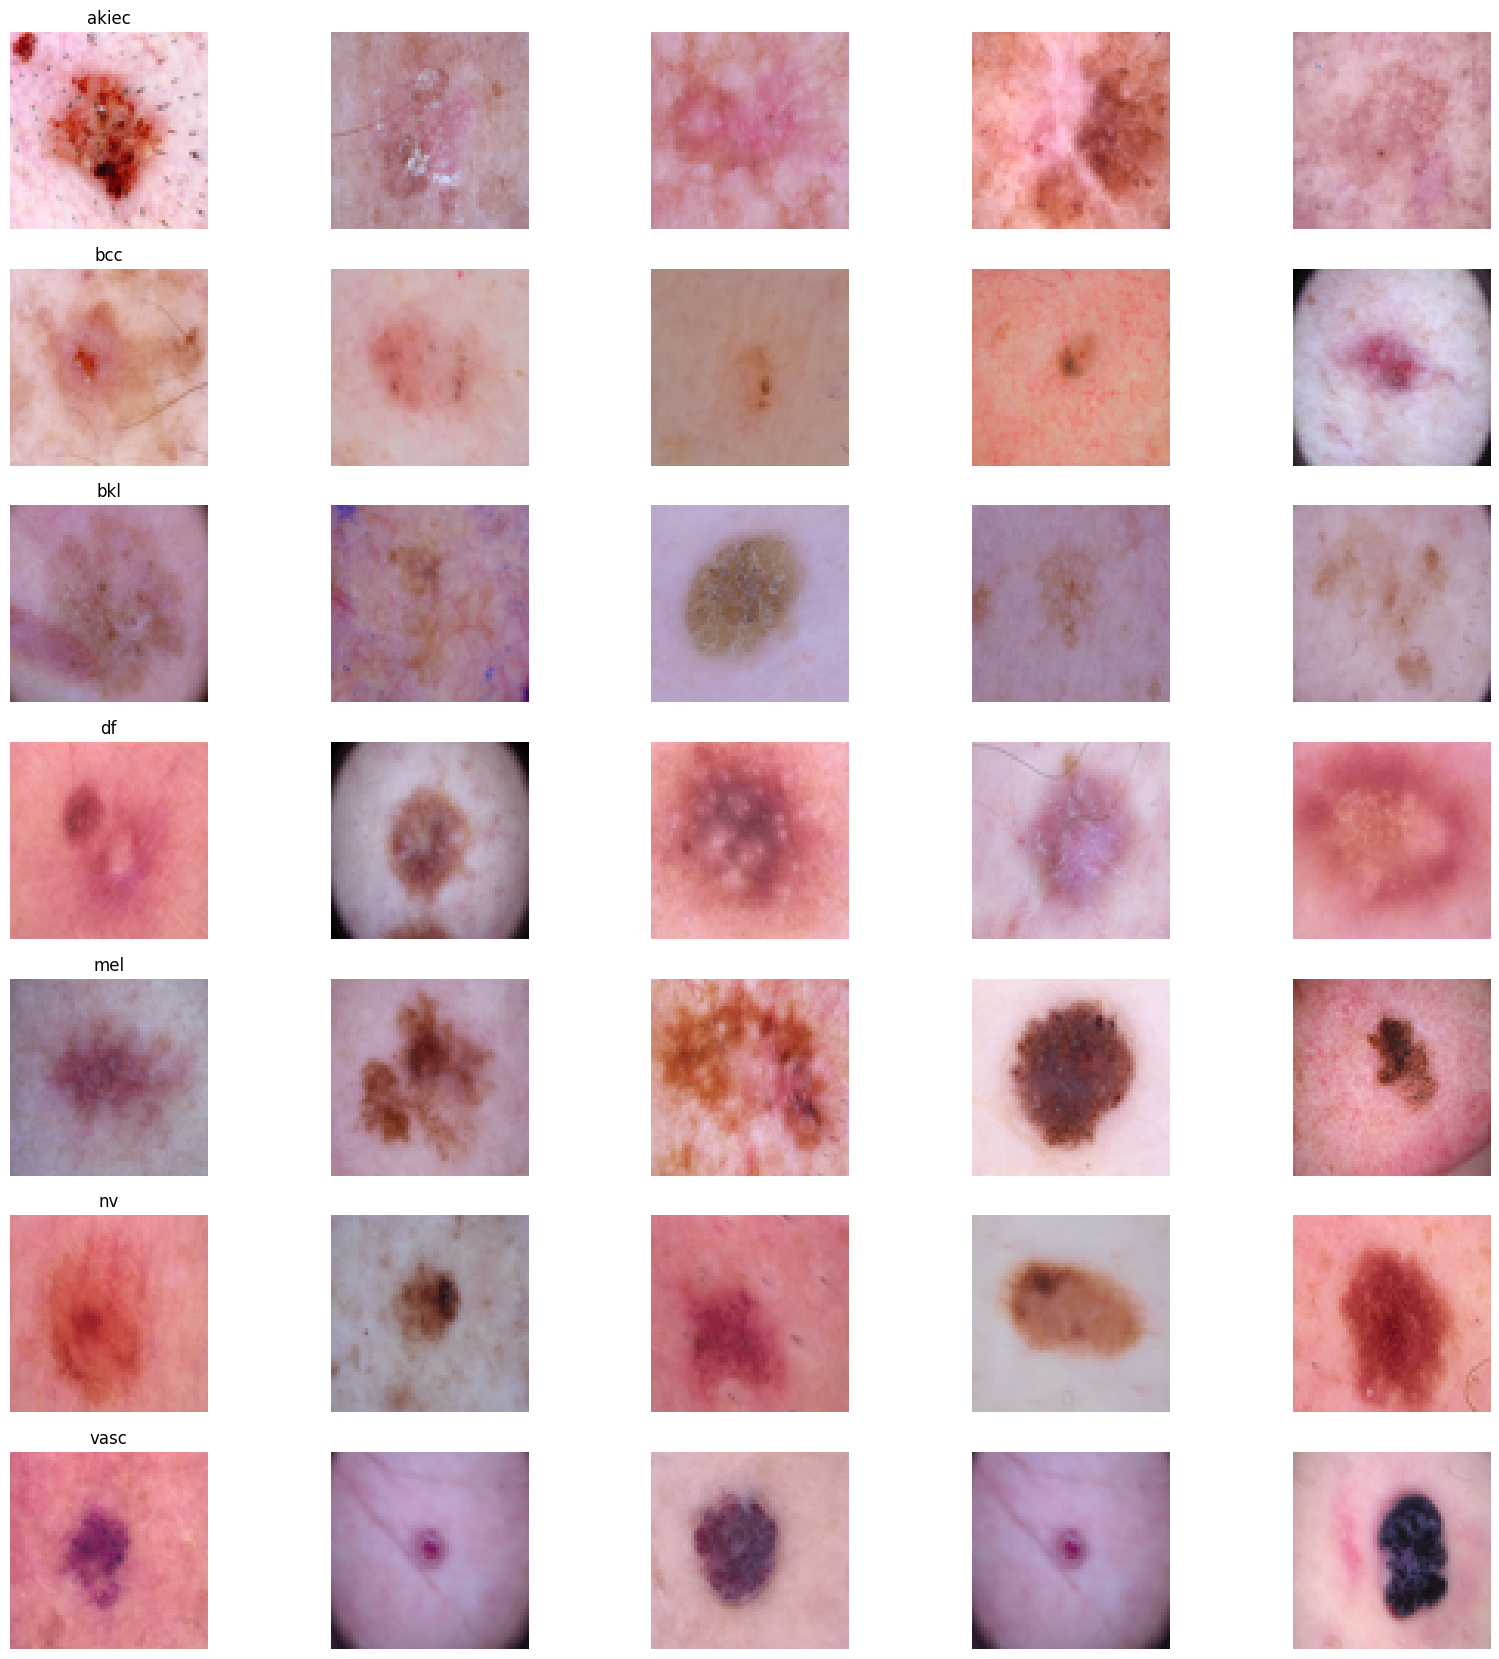

In [31]:
n_samples = 5  # number of samples for plotting
# Plotting
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs,
                                         df.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [32]:
#Convert dataframe column of images into numpy array
X = np.asarray(df['image'].tolist())
X = X/255.  # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=df['label']  #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)


In [33]:
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(2625, 64, 64, 3) (875, 64, 64, 3)
(2625, 7) (875, 7)


In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(x_train)

In [35]:
#Define the model.
#I've used autokeras to find out the best model for this problem.
#You can also load pretrained networks such as mobilenet or VGG16

num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(64, 64, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))

d:\SIB\Capstone Projek\KlasifikasiKankerKulit - Copy\MyProject\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [36]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 256)    │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 31, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 31, 31, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │        73,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 449,991 (1.72 MB)

 Trainable params: 449,991 (1.72 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

In [38]:
# Train
history = model.fit(
    x_train, y_train,
    epochs=100,
    batch_size = 16,
    validation_data=(x_test, y_test),
    verbose=2)

Epoch 1/100
165/165 - 62s - 379ms/step - acc: 0.1901 - loss: 1.9156 - val_acc: 0.2069 - val_loss: 1.8305
Epoch 2/100
165/165 - 51s - 309ms/step - acc: 0.2438 - loss: 1.8126 - val_acc: 0.2629 - val_loss: 1.7518
Epoch 3/100
165/165 - 52s - 312ms/step - acc: 0.3010 - loss: 1.7086 - val_acc: 0.3257 - val_loss: 1.6697
Epoch 4/100
165/165 - 50s - 304ms/step - acc: 0.3596 - loss: 1.5485 - val_acc: 0.3600 - val_loss: 1.5904
Epoch 5/100
165/165 - 49s - 296ms/step - acc: 0.3886 - loss: 1.5023 - val_acc: 0.4297 - val_loss: 1.4557
Epoch 6/100
165/165 - 50s - 301ms/step - acc: 0.4484 - loss: 1.3987 - val_acc: 0.4423 - val_loss: 1.4931
Epoch 7/100
165/165 - 51s - 307ms/step - acc: 0.4667 - loss: 1.3400 - val_acc: 0.5154 - val_loss: 1.3235
Epoch 8/100
165/165 - 49s - 296ms/step - acc: 0.5025 - loss: 1.2874 - val_acc: 0.5280 - val_loss: 1.3117
Epoch 9/100
165/165 - 81s - 493ms/step - acc: 0.4983 - loss: 1.2611 - val_acc: 0.5634 - val_loss: 1.2294
Epoch 10/100
165/165 - 49s - 299ms/step - acc: 0.5272 -

In [39]:
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - acc: 0.7657 - loss: 1.0301
Test accuracy: 0.7577142715454102


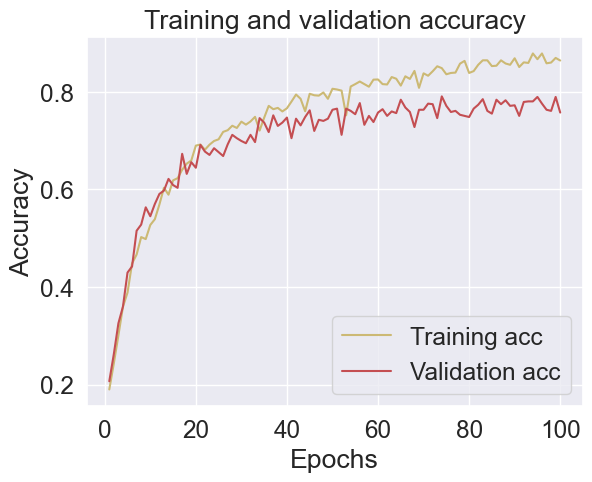

In [48]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

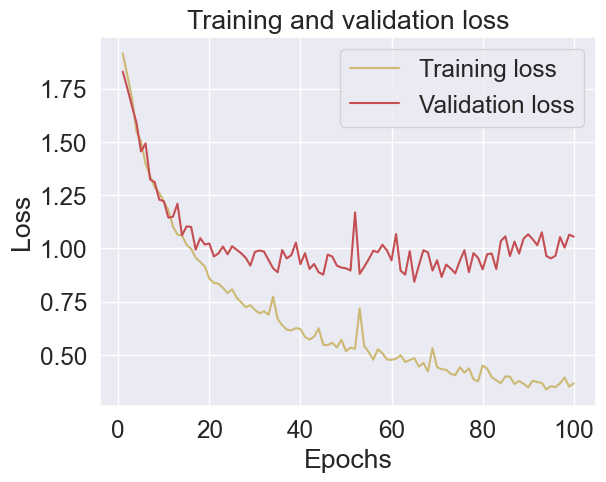

In [50]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [52]:
# Prediction on test data
y_pred = model.predict(x_test)
y_true = np.argmax(y_test, axis = 1)
# Convert predictions classes to one hot vectors
y_pred_lb = np.argmax(y_pred, axis = 1)
print(y_pred_lb)

28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step
[3 4 5 3 0 2 3 3 2 0 3 5 6 1 1 1 1 2 6 5 0 3 4 3 1 4 1 2 3 6 6 3 4 1 6 6 0
 0 1 4 3 6 1 2 4 0 3 3 3 0 0 2 5 6 5 0 2 0 2 3 6 2 2 0 3 6 0 3 3 5 4 1 2 2
 1 3 6 5 6 3 6 6 6 6 5 5 2 5 0 0 0 6 1 4 6 5 0 2 3 1 0 5 4 1 2 0 6 6 1 0 0
 1 2 1 4 5 6 1 5 3 1 5 6 2 2 2 5 3 1 0 3 0 0 6 4 4 6 6 2 1 5 6 5 3 4 5 4 1
 2 0 0 3 4 5 5 5 0 3 0 3 6 5 2 5 6 1 6 5 0 3 3 3 0 2 3 6 1 4 1 6 6 2 2 0 2
 5 2 3 3 5 4 5 6 4 4 6 5 3 2 5 2 0 3 2 0 2 5 6 6 2 2 0 6 6 6 6 6 2 2 5 2 1
 3 1 5 3 6 2 3 3 4 3 1 6 1 3 4 3 0 1 2 0 2 5 3 3 4 2 6 3 2 6 3 1 3 3 5 4 1
 3 4 0 0 5 6 2 3 4 0 1 6 1 0 1 0 0 0 6 5 3 2 3 0 6 0 1 0 4 4 6 5 1 3 2 4 5
 5 1 1 3 1 0 2 6 4 1 2 1 2 4 6 6 1 5 1 6 2 1 4 0 5 6 2 4 2 5 0 3 1 1 2 1 6
 5 4 3 0 2 4 2 3 0 3 4 4 0 4 3 5 4 3 6 0 3 6 4 3 5 2 3 3 1 4 0 2 6 0 1 0 4
 5 6 2 3 4 4 0 2 6 3 5 0 4 3 2 1 0 4 4 2 0 5 4 2 0 4 3 5 0 0 5 0 4 3 2 3 0
 4 5 3 1 4 3 2 5 4 5 5 3 1 6 6 6 6 0 4 2 3 6 2 3 5 5 0 3 0 6 1 4 0 2 4 0 2
 1 2 5 3 6 6 0 3 5 1 4 6 6 1 0 2 1 0 6 4 5 0 0 0 3 6 3 5 6 

In [55]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred_lb)
print(cm)

[[109  13  14   6   4   3   0]
 [  1  94  13   8   5   7   0]
 [  1   6  74   1  24  11   3]
 [  0   1   0 126   1   0   0]
 [  7   2  18   4  61  19   1]
 [  2   2  11   3  17  74   4]
 [  0   0   0   0   0   0 125]]


In [54]:
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report
class_labels=['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
# Generate classification report
report = classification_report(y_true, y_pred_lb,target_names=class_labels)

# Print the report
print(report)

              precision    recall  f1-score   support

       akiec       0.91      0.73      0.81       149
         bcc       0.80      0.73      0.76       128
         bkl       0.57      0.62      0.59       120
          df       0.85      0.98      0.91       128
         mel       0.54      0.54      0.54       112
          nv       0.65      0.65      0.65       113
        vasc       0.94      1.00      0.97       125

    accuracy                           0.76       875
   macro avg       0.75      0.75      0.75       875
weighted avg       0.76      0.76      0.76       875



In [59]:
model.save('kanker2.h5')